**GIANLUCA DI TUCCIO, EXAM 10-06-2022, IMAGE GAUSSIAN DEBLURRING**

# INTRODUCTION


Model: Modified DnCNN + SRCNN<br>
Test Set MSE: 0.0021539<br>
Trainable Parameters: 215 k<br>
Epochs: 70<br>
Optimizer: Adam



The main task is to solve the noise and the gaussian blur in an image. Besides, it is also important to remember that it's impossible to obtain the original image from the blurred one, because after the blurring some original data are lost. For this task, I have preferred to use a simple/fast architecture than complex models that already exist, using the least number of parameters.<br>
I use the [DnCNN](https://www.researchgate.net/publication/306187437_Beyond_a_Gaussian_Denoiser_Residual_Learning_of_Deep_CNN_for_Image_Denoising) (Denoising Convolutional Neural Networks) model for the denoising, proposed by the Harbin Institute of Technology and The Hong Kong Polytechnic University, and [SRCNN](https://arxiv.org/abs/1501.00092) (Super-Resolution) for deblurring the image. From these models, I add and modify some parts for adapting the entire model to our dataset (32x32x3 images), such as the number of layers, the size of filters, Subtract layer, etc, with all the considerations regarding these parts.<br>
However, there are different type of blur (subject movement, camera movement, out of focus, etc) and it exists different model, such as:
- DeepDeblur;
- PSS-NSC;
- MT-RNN;
- MIMO-UNet.<br>

The paper Rethinking Coarse-to-Fine Approach in Single Image Deblurring, Sung-Jin Cho, 2021, proposes some of these (https://arxiv.org/pdf/2108.05054.pdf).<br><br>
Recommended articles: 
- [SRCNN Paper Summary & Implementation, Sieun Park, 2021](https://medium.com/analytics-vidhya/srcnn-paper-summary-implementation-ad5cea22a90e)
- [Noise removal in images using deep learning models, Sunil Belde, 2021](https://medium.com/analytics-vidhya/noise-removal-in-images-using-deep-learning-models-3972544372d2)


In [2]:
# Library
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import tensorflow as tf 
import random
from cv2 import GaussianBlur

# GET DATASET

In [3]:
def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

In [4]:
train, test = getDataset()

# get the train part (subdivided into noise and target)
train_noise = train[0]
train_target = train[1]

# get the test part (subdivided into noise and target)
test_noise = test[0]
test_target = test[1]

170508288/170498071 [==============================] - 2s 0us/step


# DnCNN
![1](https://raw.githubusercontent.com/DitucSpa/ImageGaussianDeblurring/main/Images/DnCNN.png)
<br>
Given a noisy image, the model tries to predict the residual image (as shown in the upper image). It's composed by:
- the first layer with Conv + ReLu of 64 filters 3x3;
- a series of Conv + Batch Normalization + ReLu, 64 filters 3x3 for layer.
- the last layer with only the Conv of 3 filters 1x1.
<br>

This model works both for gray and color image.<br>
From this, we can obtein a denoise image using the Residual Learning, as:<br>
Clean Image = Subtract(Noise Image - Predicted Residual Image).
![1](https://raw.githubusercontent.com/DitucSpa/ImageGaussianDeblurring/main/Images/residual_learning.png)

# SRCNN
![1](https://raw.githubusercontent.com/DitucSpa/ImageGaussianDeblurring/main/Images/srcnn.png)


The SRCNN is a model for image super-resolution. It's subdivided into three path:
- patch extraction and representation;
- non linear mapping (for introducing more non-linearity to improve theaccuracy);
- reconstruction.
This model is also used for deblurring an image.

# FIND THE BEST CONFIGURATION

Before the fit of the model, it's important to choose the best configuration for the model (such as number of layers in the middle, filter dimension, number of filters, and so on). <br><br>
!!! IMPORTANT NOTE!!!<br>
For all the configurations, the SRCNN part (for deblurring) has remained the same, because there have not been important improvements. So, I have decided to change (and semplify) only the DnCNN part, with important improvements on the result. The follow blocks explain what to change for adapting the model to the our datast (32x32x3). I have also tried to use the least number of parameters, for a simply and fast model for the training.

**DnCNN: NUMBER OF FILTERS PER LAYER**<br>
First, I evaluate the model with different configurations for finding the better configuration. All the results were achieved using some fixed parameters, such as:
- 10 levels for the loop (10 layers of CNN + BN + ReLu);
- 3x3 filter dimension;
- "same" padding;
- 1 as stride;
- 100 as batches size;
- adam optimizer;
- same SRCNN
- 30 epochs.
<br>

The results are:
![1](https://raw.githubusercontent.com/DitucSpa/ImageGaussianDeblurring/main/Images/ResultsWithDifferentFilter.png)
The results for 10 layers with 128 filters (or 8 filters) for each level are not shown, because the performances were really bad (128 filters were too many for this dataset with 32x32x3 images, while 8 were too few).<br>
The highlighted yellow rows show the best configuration:
- the configuration with the lowest MSE with only 64 filters per layer (with high parameters) --> MSE = 0.0024 with 402.0k parameters;
- the configuration with a good MSE with 32-64 filters per layer alternated (es: 64-32-64-32 and so on) --> MSE = 0.0025 with 215.1k parameters.

However, given that the MSE for the 32-64 alternated configuration is near to the MSE of the 64 filters configuration, the 32-64 configuration could be better than other configurations, because this configuration uses half of the parameters than the 64 filters per layer configuration. Indeed, I will evaluate both configurations.
<br>
Besides, there's another configuration (highlighted in blue) that shows the configuration with the lowest parameters (but the MSE is not optimal).

**DnCNN: FILTER SIZE**<br>
Besides, another paper has proposed a different architecture (autoencoder) with a 2x2 filter size (https://github.com/done-n-dusted/deblur-fashionmnist) with stride=1, because of the dataset (*fashionmnist*) with a 28x28x1 image dimension. As you can imagine, the *fashionmnist* dataset has images with 1 channel color instead of our 3 channel colors, thus the 2x2 filter size may not be enough (choosing odd kernel sizes has the benefit that we can preserve the spatial dimensionality). Indeed, the results were (with the same parameters as before, tested only for 32 filters per layer and 32-64 alternated):
![2](https://raw.githubusercontent.com/DitucSpa/ImageGaussianDeblurring/main/Images/ResultsWithDifferentFilterSize.png)
For the 16 filters per layers and the 16-32 alternated, the results were worse than before, thus the results are not reported in the table. Also, with the same results I choose the model with less parameters.<br>
The 5x5 filter size achieves the better MSE for 32-64 alternated, but with 546.2k parameters, while the 3x3 filter size was close to the 5x5 MSE with only 215.5k parameters. Thus, I decide to use filters with a 3x3 size. Also, the 3x3 - 64 filters configuration achieves the same result (0.0024) using fewer parameters (402.0k instead of 546.2k).
However, I have seen that using a 5x5 filter size for the first and last convolution and the others with a 3x3 filter size, the results were better 4 times out 5. Indeed, kernels with a large size can be helpful for incorporating information with large receptive fields, but two successive layers can increase the receptive field, mitigating this advantage.
![3](https://raw.githubusercontent.com/DitucSpa/ImageGaussianDeblurring/main/Images/DnCNN_5Filters.png)
<br><br>
(The images below show accuracy rate and the processing time using different filter size, for differenti input image: 66x50, 90x75 and 132x100. The results show an equal behaviour of the filter size in different input image. Paper: Analysis of Filter Size Effect In Deep Learning, Yunus Camgözlü, 2020, https://arxiv.org/pdf/2101.01115.pdf).
This is also explained by the type of images (32x32x3) that I use for the exam and for the purpose (gaussian deblurring).
![4](https://raw.githubusercontent.com/DitucSpa/ImageGaussianDeblurring/main/Images/BatchSizePaper2.png)
![5](https://raw.githubusercontent.com/DitucSpa/ImageGaussianDeblurring/main/Images/BatchSizePaper.png)

**DnCNN: NUMBER OF LAYERS (CNN + BN + RELU)**<br>
At the end, I try with different number of layers, but the results were worse than the 10 layers in the middle (same MSE with more parameters or worse MSE). Besides, I try to add some addition but without an important increase of performance, like the Squeezy and Excitation (code proposed by https://github.com/titu1994/keras-squeeze-excite-network) and some 1x1 Convolutional for reducing the depth numbers in the middle.<br>
Also another [paper](https://arxiv.org/pdf/1705.03122.pdf) proposes some considerations regarding the number of filters and the number of layers (even if the paper have used Autoencoder, but the results were the same). Indeed, the more the layers, the lower the accuracy (or MSE) for bigger filter size. But, this inverse correlation isn't very large, so using small filter size and few number of layers is a better choise.


**CONCLUSION**<br>
In conclusion, the configurations choosen for the model are:
- 10 layers in the middle (CNN + BN + LReLU);
- 3x3 filter dimension for the middle layers;
- 5x5 filter dimension for the first and last convolution;
- 1 as stride;
- "same" padding;
- 30 epochs;
- adam optimazers;
- 32 and 64 filters per layer in the middle architecture or 64 filters per layer;
- same SRCNN.
<br>

Besides, there have been better results using [Leaky ReLu](https://keras.io/api/layers/activation_layers/leaky_relu/) (it fixes the “dying ReLU” problem --> it doesn’t have the zero-slope part) and a tanh actvivation in the first layer.

In [7]:
# library used
from keras.models import Model
from keras.layers import Input, Conv2D, Activation, BatchNormalization, Subtract, PReLU, Add, Conv2DTranspose

# input
input_shape = train_noise[0].shape
input = Input(shape=input_shape, name = "InputLayer")

# all the filters are initialize with a "random normal", while bias with zero.
# the padding is the same and the stride is equal to 1 (by default)


# ---------------------DnCNNN---------------------
# first layer of the DnCNN, with 32 5x5 filters
dncnn = Conv2D(32, kernel_size=(5,5), kernel_initializer="random_normal", bias_initializer="zeros", 
           padding="same", name = "DnCNN_FirstConvLayer")(input)
dncnn = Activation("tanh", name = "DnCNN_FirstActivation_tanh")(dncnn)

# middle layers (10 levels) --> 64-32-64-32-etc
for i in range(10):
  if i%2 == 0:
    dncnn = Conv2D(64, kernel_size=(3,3), kernel_initializer="random_normal", bias_initializer="zeros", 
               padding="same", name = f"DnCNN_{i}_64")(dncnn)
    dncnn = BatchNormalization(axis=-1, name = f"DnCNN_{i}_BN")(dncnn)
    dncnn = Activation("leaky_relu", name = f"DnCNN_{i}_Activation_LeakyReLu")(dncnn)
  else:
    # or alternatively 64 insted of 32 for the model with all 64 filters per layer
    dncnn = Conv2D(32, kernel_size=(3,3), kernel_initializer="random_normal", bias_initializer="zeros", 
               padding="same", name = f"DnCNN_{i}_32")(dncnn)
    dncnn = BatchNormalization(axis=-1, name = f"DnCNN_{i}_BN")(dncnn)
    dncnn = Activation("leaky_relu", name = f"DnCNN_{i}_Activation_LeakyReLu")(dncnn)

# last layer, 3 filters (for the RGB images) and 5x5 filter dimension
dncnn = Conv2D(3, kernel_size=(5,5), kernel_initializer="random_normal", bias_initializer="zeros", 
           padding="same", name = "DnCNN_LastConvLayer")(dncnn)

# subtract
dncnn = Subtract(name = "DnCNN_SubtractLayer")([input, dncnn])



# ---------------------SRCNN---------------------
srcnn = Conv2D(64, kernel_size=(9,9), kernel_initializer="random_normal", bias_initializer="zeros", 
           padding="same", activation="relu", name = "SRCNN_9x9_Layer")(dncnn)
srcnn = Conv2D(64, kernel_size=(1,1), kernel_initializer="random_normal", bias_initializer="zeros", 
           padding="same", activation="relu", name = "SRCNN_1x1_Layer")(srcnn)
srcnn = Conv2D(3, kernel_size=(5,5), kernel_initializer="random_normal", bias_initializer="zeros", 
           padding="same", activation="relu", name = "SRCNN_5x5_Layer")(srcnn)

model = Model(input, srcnn, name = "DiTuccio_Modified_DnCNN")
model.summary()

Model: "DiTuccio_Modified_DnCNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 DnCNN_FirstConvLayer (Conv2D)  (None, 32, 32, 32)   2432        ['InputLayer[0][0]']             
                                                                                                  
 DnCNN_FirstActivation_tanh (Ac  (None, 32, 32, 32)  0           ['DnCNN_FirstConvLayer[0][0]']   
 tivation)                                                                                        
                                                                                                  
 DnCNN_0_64 (Conv2D)            (None, 32, 32, 64)   18496       ['DnCNN_Fir

# SPLIT TRAIN, OPTIMIZER AND VALIDATION

In [8]:
from keras import optimizers

validation_split = 0.1 # the dataset is big, then 0.1 is enough

# train
train_for_fit = train_noise[:int(train_noise.shape[0]*(1-validation_split))]
target_for_fit = train_target[:int(train_target.shape[0]*(1-validation_split))]

# validation
val_train = train_noise[-int(train_noise.shape[0]*validation_split):]
val_target = train_target[-int(train_target.shape[0]*validation_split):]

# learning rate (the learning rate is a hyperparameter --> this is the best configuration)
# https://keras.io/api/callbacks/learning_rate_scheduler/
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  elif epoch > 50:
    return 0.00005
  else:
    return lr * 0.97

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
adam = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss = 'mse', optimizer = adam)

# BATCH SIZE AS HYPERPARAMETER AND FIT OF THE MODEL

Now, the main purpose is to set the number of batch (as hyperparameter). The [paper](https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU) shows that often the smaller the batch size the better the results (but also the computation time is worse). Also another [paper](https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e) proposes the same reasoning  using MNIST dataset.<br>
Thus, I expect better result for small batch size (like 32 or 50) than big batch size (100, 200, 500), tested for 30 epochs.
The table below shows the result achieved:
![6](https://raw.githubusercontent.com/DitucSpa/ImageGaussianDeblurring/main/Images/BatchSize2.png)
![7](https://raw.githubusercontent.com/DitucSpa/ImageGaussianDeblurring/main/Images/BatchSizeGraph2.png)

At the end, the difference between the 32-64 alternated model and the 64 model isn't very large, so I've decided to use the first model, using only 215.5k parameters, with an appropriate LR and 70 epochs.

In [9]:
from keras.callbacks import ModelCheckpoint

# save model using callback
check_model_callback = ModelCheckpoint(filepath = "dituccio_model.hdf5", monitor="val_loss", verbose=1, save_best_only=True, 
                             save_weights_only=True, mode="auto", save_freq="epoch")

# fit of the model
history = model.fit(train_for_fit, target_for_fit, batch_size=50, epochs=70, 
                    shuffle=True, validation_data=(val_train, val_target),
                    callbacks=[check_model_callback, callback], verbose = 1)

Epoch 1/70
899/900 [============================>.] - ETA: 0s - loss: 0.0064
Epoch 1: val_loss improved from inf to 0.00396, saving model to dituccio_model.hdf5
900/900 [==============================] - 44s 36ms/step - loss: 0.0064 - val_loss: 0.0040 - lr: 0.0010
Epoch 2/70
899/900 [============================>.] - ETA: 0s - loss: 0.0036
Epoch 2: val_loss improved from 0.00396 to 0.00347, saving model to dituccio_model.hdf5
900/900 [==============================] - 32s 36ms/step - loss: 0.0036 - val_loss: 0.0035 - lr: 0.0010
Epoch 3/70
899/900 [============================>.] - ETA: 0s - loss: 0.0031
Epoch 3: val_loss improved from 0.00347 to 0.00305, saving model to dituccio_model.hdf5
900/900 [==============================] - 32s 35ms/step - loss: 0.0031 - val_loss: 0.0030 - lr: 0.0010
Epoch 4/70
899/900 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 4: val_loss improved from 0.00305 to 0.00284, saving model to dituccio_model.hdf5
900/900 [=======================

In [10]:
def display_history(history):
    mse_training = history.history['loss']
    mse_val = history.history['val_loss']
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

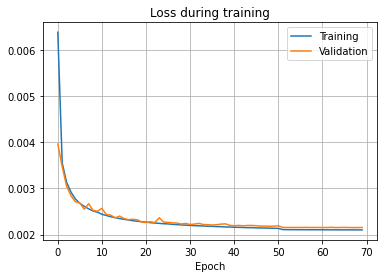

In [11]:
display_history(history)

# LOAD THE WEIGHTS AND RE-EVALUATE THE MODEL

The performance on the test set is practically the same (no overfitting; there is a slight difference at the end, but it's very small). Also the dataset is big and for this model (DnCNN + SRCNN), data augmentation is not needed.

In [12]:
# load the model
checkpoint_path = "dituccio_model.hdf5"
model.load_weights(checkpoint_path)

# test set
score = model.evaluate(test_noise, test_target, verbose=2)
print(f"The MSE for the test set is:\t{score}")

313/313 - 4s - loss: 0.0022 - 4s/epoch - 13ms/step
The MSE for the test set is:	0.002153907436877489


# IMAGE RESULTS

In [13]:
def plot_image_results(number_of_image):
  fig = plt.figure(figsize=(12, 12))

  # noise image
  fig.add_subplot(1, 3, 1)
  plt.imshow(test_noise[number_of_image])
  plt.title("Noise Image")

  # original image
  fig.add_subplot(1, 3, 2)
  plt.imshow(test_target[number_of_image])
  plt.title("Original Image")

  # Modified DnCNN
  fig.add_subplot(1, 3, 3)
  pred = model.predict(test_noise[number_of_image].reshape(-1, 32, 32, 3))
  plt.imshow(pred[0])
  plt.title("Modified DnCNN")

  plt.show()
  

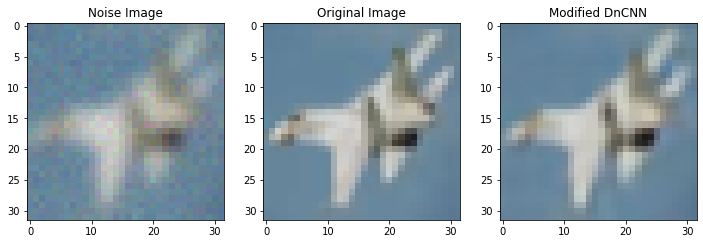

In [14]:
plot_image_results(10)